# Assignment 3: Product Segmentation
### Deadline : 04/12/2024, 10:59PM

## Context
When planning for a trip, selecting the right sneakers is crucial, and it's hard not to think immediately of Adidas and Nike. These brands are titans in the sportswear market, each with significant market presence and share, constantly competing to be the preferred choice among consumers. As the latest addition to the data science team at a market research firm, your mission involves diving into a dataset of men's and women's footwear from these brands. Your goal is to analyze the data, cluster the products, and uncover patterns that reveal the nuances in the product offerings of Adidas and Nike.

## Objective
Your task is to conduct an exploratory data analysis (EDA) and apply clustering techniques to categorize the products based on various attributes. This analysis aims to dissect the similarities and differences within the product assortments of these leading brands.

## Key Questions
What features play a pivotal role in the clustering process?

How does each cluster distinguish itself from the others?

##Data Overview
You will be working with a dataset that includes 3,268 products from Nike and Adidas. This dataset is rich with product-specific details, such as ratings, discounts, sales and listed prices, product names, and review counts.

###Data Attributes:

*  Product Name: The name of the product.
*  Product ID: A unique identifier for the product.
*  Listing Price: The original price at which the product is listed.
*  Sale Price: The actual sale price after applying discounts.
*  Discount: The discount percentage offered on the product.
*  Brand: The brand to which the product belongs (Nike or Adidas).
*  Rating: The customer rating of the product.
*  Reviews: The total number of reviews the product has received.

This assignment will challenge you to leverage your data science skills to provide meaningful insights into the competitive landscape of Adidas and Nike's product lines.

# Task 0 - Exploratory Data Analysis Part 1

###Importing necessary libraries

In [1]:
# please uncomment and run the next line if yellowbrick library is not previously installed
# !pip install yellowbrick

In [2]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


sns.set_theme()
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

In [3]:
# loading the dataset
data = pd.read_csv("data.csv")

In [4]:
data.shape

(3268, 8)

* The dataset has 3268 rows and 8 columns

In [5]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,Product Name,Product ID,Listing Price,Sale Price,Discount,Brand,Rating,Reviews
255,Women's adidas Originals POD-S3.1 Shoes,CG6188,13999,6999,50,Adidas ORIGINALS,3.3,8
1551,Men's adidas Originals Superstar Pure Shoes,FV3013,11999,11999,0,Adidas ORIGINALS,3.9,10
1352,Men's adidas Originals Superstar Shoes,FV2806,7999,7999,0,Adidas ORIGINALS,4.4,42
1060,Men's adidas Football Nemeziz 19.3 Indoor Shoes,F34411,5999,3599,40,Adidas SPORT PERFORMANCE,4.5,75
808,Men's adidas Sport Inspired Court 80s Shoes,EE9676,5999,3599,40,Adidas CORE / NEO,4.5,55
836,Men's adidas Running Stargon 1.0 Shoes,CM4935,4799,3839,20,Adidas CORE / NEO,3.5,21
2107,Men's adidas Originals Yung-96 Chasm Shoes,EE7238,7999,4799,40,Adidas ORIGINALS,3.0,62
3002,Nike SB Air Max Stefan Janoski 2,AQ7477-009,0,9995,0,Nike,2.6,11
2329,Men's adidas Originals Rivalry Low Shoes,FV4287,10999,10999,0,Adidas ORIGINALS,2.8,8
602,Men's adidas Sport Inspired Lite Racer RBN Shoes,F36642,5599,3919,30,Adidas CORE / NEO,3.0,56


In [6]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

In [7]:
# fixing column names
df.columns = [c.replace(" ", "_") for c in df.columns]

In [8]:
# let's look at the structure of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3268 entries, 0 to 3267
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product_Name   3268 non-null   object 
 1   Product_ID     3268 non-null   object 
 2   Listing_Price  3268 non-null   int64  
 3   Sale_Price     3268 non-null   int64  
 4   Discount       3268 non-null   int64  
 5   Brand          3268 non-null   object 
 6   Rating         3268 non-null   float64
 7   Reviews        3268 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 204.4+ KB


**We won't need Product_ID for analysis, so let's drop this column.**

In [9]:
df.drop("Product_ID", axis=1, inplace=True)

In [10]:
# let's check for duplicate observations
df.duplicated().sum()

117

- There are 117 duplicate observations. We will remove them from the data.

In [11]:
df = df[(~df.duplicated())].copy()

**Let's take a look at the summary of the data**

In [12]:
df.describe()

,Listing_Price,Sale_Price,Discount,Rating,Reviews
count,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000
mean,7045.960330,5983.166931,27.860997,3.285687,41.891146
std,4652.089511,4173.708897,22.442753,1.371611,31.283464
min,0.000000,449.000000,0.000000,0.000000,0.000000
25%,4599.000000,2999.000000,0.000000,2.600000,12.000000
50%,5999.000000,4599.000000,40.000000,3.600000,40.000000
75%,8999.000000,7799.000000,50.000000,4.400000,69.000000
max,29999.000000,36500.000000,60.000000,5.000000,223.000000


**Observations**

- 0 in the listing price indicates missing values.
- The average listing price is 7046.
- The average sale price is 5983.
- The average discount is 28%.
- The average rating is 3.3.
- The average number of reviews is 42.

# Task 1 - Exploratory Data Analysis Part 2

**1) How many products have listing price 0? (2 points)**

In [13]:
# Stricly finds values equal to 0 for listing price
zero_values_total = df[df["Listing_Price"] == 0]
print(f"{len(zero_values_total)} product names in the table have a listing price of 0")

336 product names in the table have a listing price of 0


**2) Utilize the pandas describe() function to generate a summary of the statistical characteristics of products with a listing price of 0. (2 points)**

In [14]:
print(zero_values_total.describe())

       Listing_Price    Sale_Price  Discount      Rating     Reviews
count          336.0    336.000000     336.0  336.000000  336.000000
mean             0.0  11203.050595       0.0    2.797619    8.261905
std              0.0   4623.825788       0.0    2.150445   19.708393
min              0.0   1595.000000       0.0    0.000000    0.000000
25%              0.0   7995.000000       0.0    0.000000    0.000000
50%              0.0  10995.000000       0.0    3.950000    1.000000
75%              0.0  13995.000000       0.0    4.700000    6.000000
max              0.0  36500.000000       0.0    5.000000  223.000000


**3) Replace the listing price with the corresponding sale price for products with a listing price of 0. (4 points)**

In [15]:
# Copy the original DataFrame
df_copy = df.copy()

# Identify rows where Listing_Price is zero
zero_values_total = df_copy["Listing_Price"] == 0

# Replace Listing Price with Sale Price where Listing Price is zero in the copy
df_copy.loc[zero_values_total, "Listing_Price"] = df_copy.loc[zero_values_total, "Sale_Price"]

print("Total of Listing prices still 0: (Should be None/0)", {sum(df_copy["Listing_Price"] == 0)})
print("--------------------------------------------------------")
print(df_copy.describe()) # Minimum for listing shouldnt be 0 now


Total of Listing prices still 0: (Should be None/0) {0}
--------------------------------------------------------
       Listing_Price    Sale_Price     Discount       Rating      Reviews
count    3151.000000   3151.000000  3151.000000  3151.000000  3151.000000
mean     8240.573151   5983.166931    27.860997     3.285687    41.891146
std      4363.018245   4173.708897    22.442753     1.371611    31.283464
min       899.000000    449.000000     0.000000     0.000000     0.000000
25%      4999.000000   2999.000000     0.000000     2.600000    12.000000
50%      7599.000000   4599.000000    40.000000     3.600000    40.000000
75%     10995.000000   7799.000000    50.000000     4.400000    69.000000
max     36500.000000  36500.000000    60.000000     5.000000   223.000000


**4) Check missing values for all columns. (2 points)**

In [16]:
# Check for missing values in all columns
missing_values = df.isna().sum()

# Count of missing values for each column
print("Missing values count for each column:")
print(missing_values)

Missing values count for each column:
Product_Name     0
Listing_Price    0
Sale_Price       0
Discount         0
Brand            0
Rating           0
Reviews          0
dtype: int64


# Task 2 - Data Visualization

In [17]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

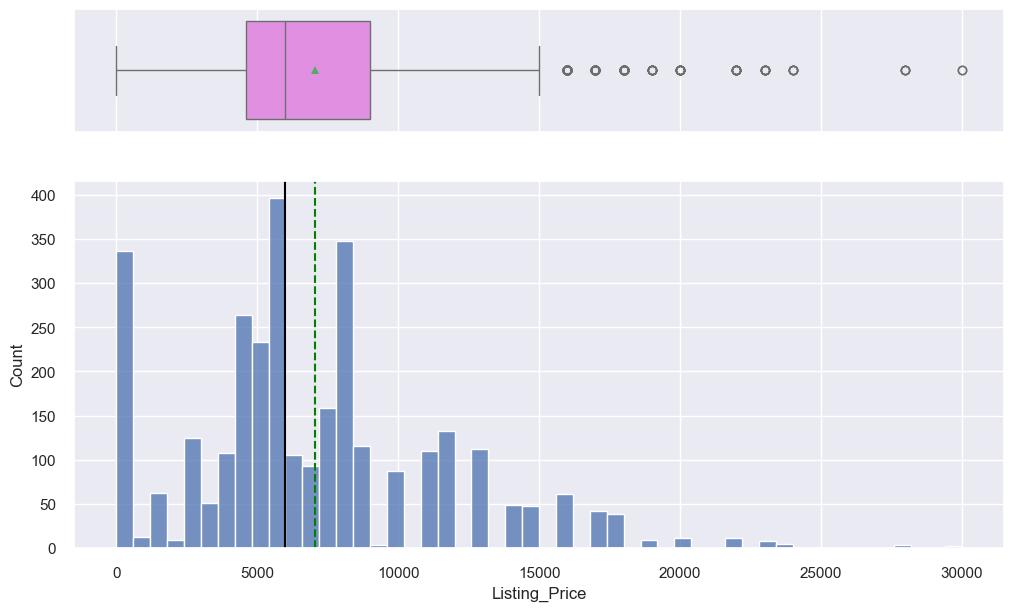

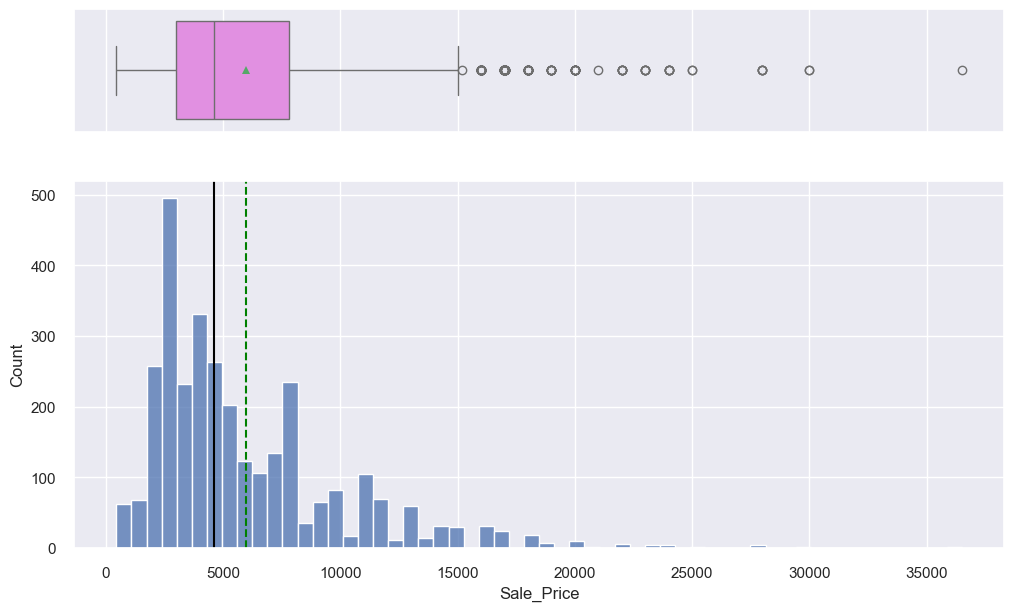

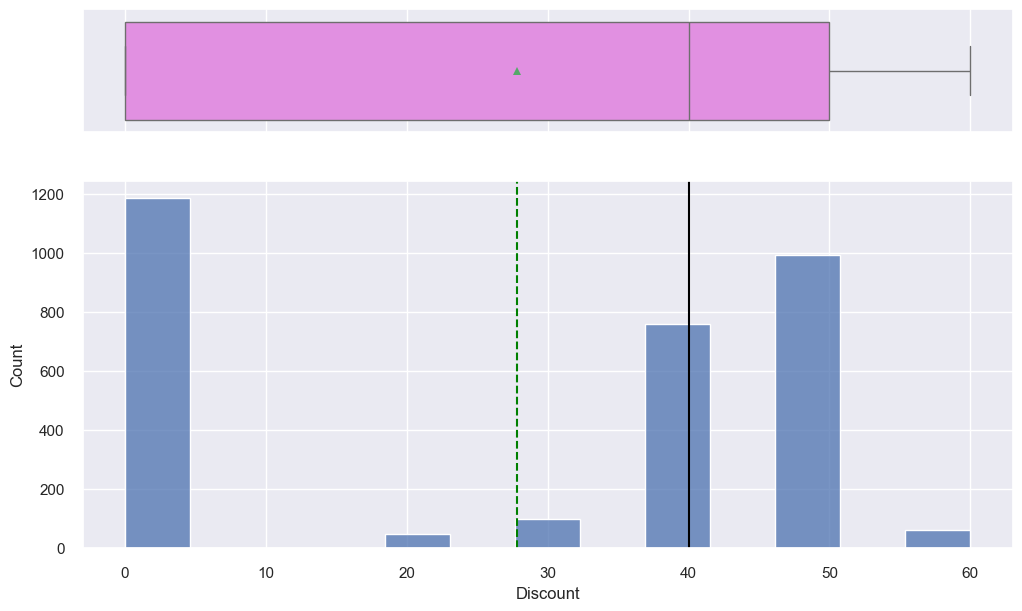

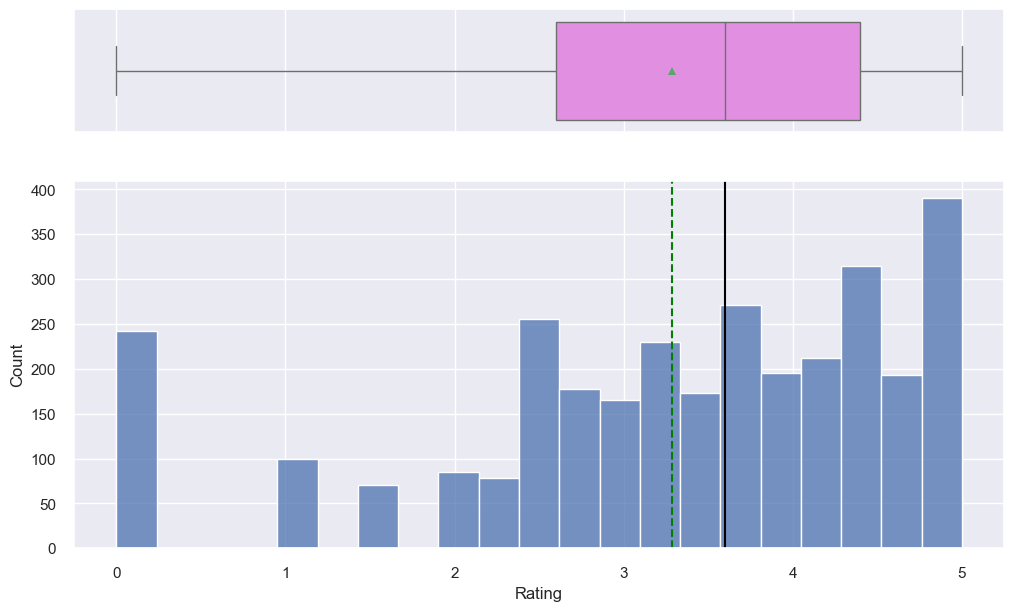

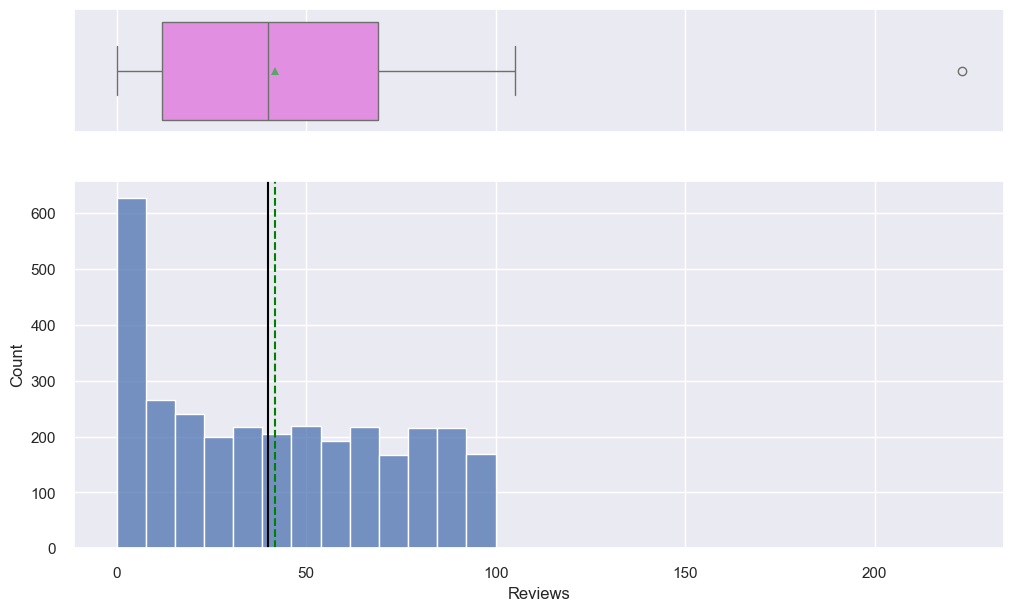

In [18]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(df, item)

**1) Please examine the provided histograms and boxplots, and write a brief sentence for each of the following attributes: listing price, sale price, discount, rating, and reviews, drawing from your observations. Ensure your response is brief and to the point. (10 points)**


Write your answer here ->
Listing Price:  The listing price is right skewed. Half of all shoes had a listing price less than about 6000. There were many shoes that did not have a Listing price documented (default to 0).

Sale Price: Similar to the listing price, it is right skewed and half of all shoes had a sale price less than about 6000. There were not many shoes that sold for 0, and the sale prices, seem to trend on being higher than listing price.

Dicount: Discounts were bimodal; There was practically either not discount (0-5% discount), or a good discount (40-50% discount).

Ratings: Ratings were left skewed, trending on having higher rating rather than lower ratings, which should be the goal.

Reviews: Reviews were pretty uniform, if you dont count products with no reviews.

In [19]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

C:\Users\Aman\AppData\Local\Temp\ipykernel_8032\1031480784.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


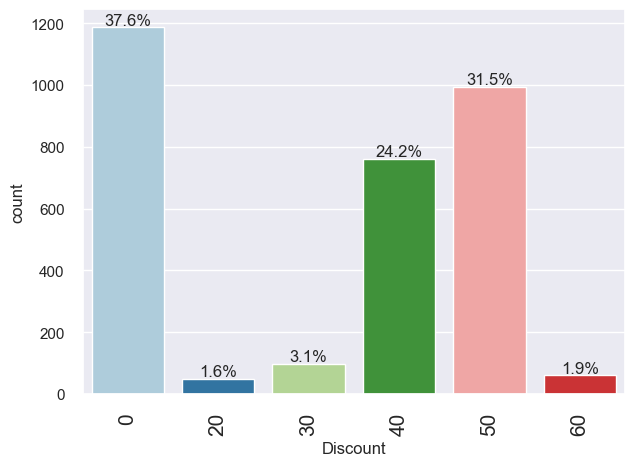

In [20]:
# let's explore discounts further
labeled_barplot(df, "Discount", perc=True)

**2) Please review the given barplot for discount and provide two concise observations. (5 points)**

Write your answer here -->
- Discount was slightly bimodal, either you recieved a good one, or you did not.
- Over half of products had a discount 40% and above.

**Let's check for correlations.**

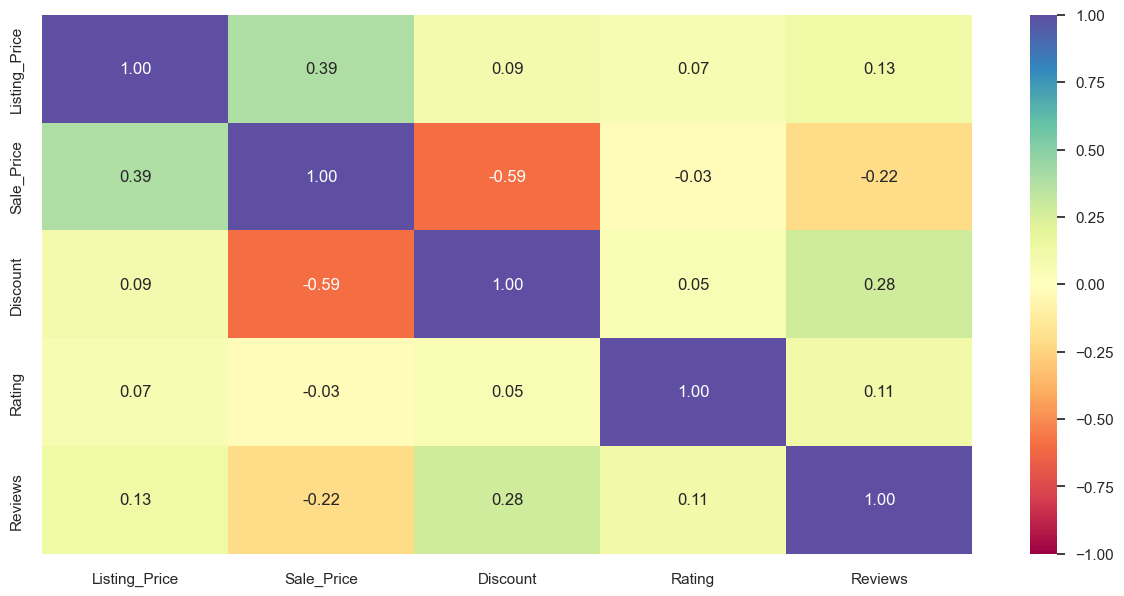

In [21]:
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**3) Please review the provided heatmap displaying listing price, sale price, discount, rating, and reviews and provide two concise observations. (5 points)**

Write your answer here -->
- There seems to be a strong correalation between sale price and listing price.
- There seems to be a weak correalation between sale price and discount. (Discount probably didnt affect sale prive and vice versa)


# Task 3: Data Preprocessing

In [22]:
# variables used for clustering
num_col

['Listing_Price', 'Sale_Price', 'Discount', 'Rating', 'Reviews']

**1) Scale the dataset before clustering by using StandardScaler() from scikit-learn (5 points)**

In [23]:
# Initialize StandardScaler
scaler = StandardScaler()

# Scale the selected columns
scaled_columns = scaler.fit_transform(df[num_col])

print(scaled_columns)

[[ 1.70983425  0.36324375  0.98662214  1.10421517 -0.02849068]
 [ 0.11889871 -0.52339865  0.98662214  0.01043677 -0.57199501]
 [-1.30004379 -1.2902245   0.54097329 -0.49999315 -0.15637405]
 ...
 [ 1.92396557  1.6328198  -1.2416221   1.25005229 -1.30732439]
 [-1.51482009  2.63879947 -1.2416221   0.52086669 -1.21141186]
 [ 0.41902655  0.07520478 -1.2416221  -2.39587571 -1.33929524]]


**2) Generate a dataframe containing the scaled columns and label it as 'subset_scaled_df' (5 points)**

In [24]:
# Create a new DataFrame with scaled columns
subset_scaled_df = pd.DataFrame(scaled_columns, columns=num_col)

# New data frame
print(subset_scaled_df)


      Listing_Price  Sale_Price  Discount    Rating   Reviews
0          1.709834    0.363244  0.986622  1.104215 -0.028491
1          0.118899   -0.523399  0.986622  0.010437 -0.571995
2         -1.300044   -1.290225  0.540973 -0.499993 -0.156374
3         -0.010096   -0.595289  0.986622  0.593785 -0.220316
4          0.204895   -0.475472  0.986622  0.156274  0.962605
...             ...         ...       ...       ...       ...
3146      -1.514820    0.122652 -1.241622 -2.395876 -1.339295
3147      -1.514820    1.919900 -1.241622 -0.208319 -1.307324
3148       1.923966    1.632820 -1.241622  1.250052 -1.307324
3149      -1.514820    2.638799 -1.241622  0.520867 -1.211412
3150       0.419027    0.075205 -1.241622 -2.395876 -1.339295

[3151 rows x 5 columns]


# Task 4: K-means Clustering

**1) Write a function that implements the "Elbow Method" for selecting the optimal number of clusters (k) for a KMeans clustering algorithm. This function should take the range of clusters and the scaled dataframe as input parameters from the user. (15 points)**

Here's what the function should do:
*   Input: Accept the range of clusters as input from the user.

*   Initializing Mean Distortions List: Create an empty list to store the average distortion for each value of k.

*   Looping through Clusters: Iterate through each value of k within the specified range.

*   Fitting the KMeans Model: Create a KMeans model with the specified number of clusters and fit it to the scaled dataframe.

*   Calculating Distortion: Compute the distortion for the fitted model using the Euclidean distance metric.

*   Storing Distortions: Append the calculated distortion to the list.

*   Printing Results: Print the number of clusters and its corresponding average distortion.

*   Plotting Elbow Curve: Generate a plot to visualize the relationship between the number of clusters and their average distortion.

*   Setting Labels and Title: Label the plot appropriately with x-axis representing the number of clusters and y-axis representing the average distortion. Set the title of the plot as "Selecting k with the Elbow Method".

*   Displaying Plot: Display the plot.


Number of clusters: 1, Average distortion: 25584.459219295477
Number of clusters: 2, Average distortion: 14360.210732835356
Number of clusters: 3, Average distortion: 11422.14551349397
Number of clusters: 4, Average distortion: 9844.121174213547
Number of clusters: 5, Average distortion: 7730.554103988374
Number of clusters: 6, Average distortion: 6437.592890871098
Number of clusters: 7, Average distortion: 5917.664266193144
Number of clusters: 8, Average distortion: 5219.930874920784
Number of clusters: 9, Average distortion: 4879.125092730306
Number of clusters: 10, Average distortion: 4528.208018773857
Number of clusters: 11, Average distortion: 4404.95960499731
Number of clusters: 12, Average distortion: 4172.543811689709
Number of clusters: 13, Average distortion: 4033.8864076151986
Number of clusters: 14, Average distortion: 3891.4829043555246
Number of clusters: 15, Average distortion: 3617.542840752636
Number of clusters: 16, Average distortion: 3377.346047489081
Number of clus

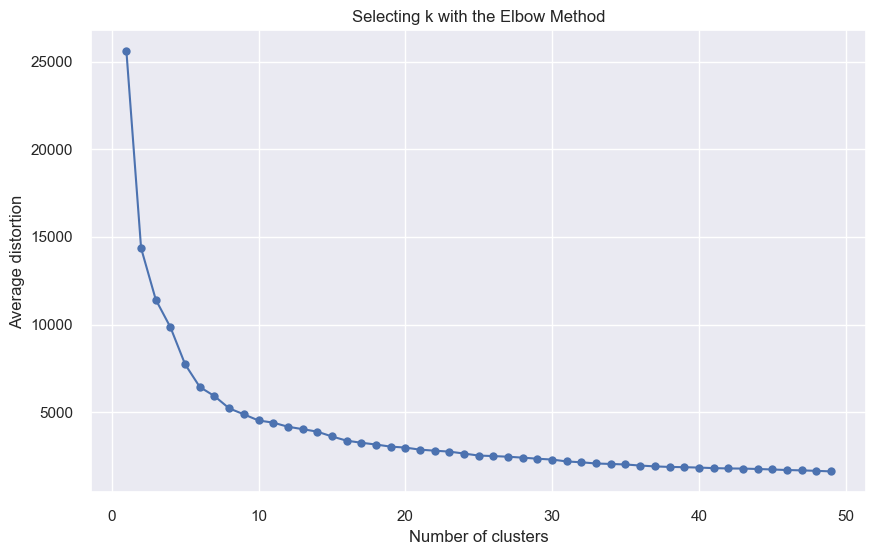

In [34]:
def elbow_method(range_of_clusters, scaled_df):
    
    # Initializing Mean Distortions Dictionary
    distortions = {}

    # Looping through Clusters
    for k in range_of_clusters:
       
        # Fitting the KMeans Model
        kmeans = KMeans(n_clusters=k, random_state=42, )
        kmeans.fit(scaled_df)
        
        # Calculating Distortion
        distortion = kmeans.inertia_
        
        # Storing Distortions
        distortions[k] = distortion
        
        # Printing Results
        print(f'Number of clusters: {k}, Average distortion: {distortion}')

    # Plotting Elbow Curve
    plt.figure(figsize=(10, 6))
    plt.plot(list(distortions.keys()), list(distortions.values()), marker='o', linestyle='-')
    
    # Setting Labels and Title
    plt.xlabel('Number of clusters')
    plt.ylabel('Average distortion')
    plt.title('Selecting k with the Elbow Method')
    
    # Displaying Plot
    plt.show()

# Example usage:
# Taking input for the range of clusters
start_cluster = int(input("Enter the start cluster: "))
end_cluster = int(input("Enter the end cluster: "))
elbow_method(range(start_cluster,end_cluster), subset_scaled_df)


**2) Based on the elbow method plot provided earlier, what is the optimal value for k? (5 points)**

write your answer here -->
Based on various trials, it seemed as if the elbow point occured at k = 6. So ill say the optimal k is k = 6


**3) Write a function that calculates the silhouette scores for a range of cluster sizes using KMeans clustering. The function should accept the scaled dataframe and a range of cluster sizes as input parameters. Then, it should iterate through each cluster size in the specified range, fit a KMeans model to the data, calculate the silhouette score, and store the scores in a list. Print the number of clusters and its corresponding silhouette scores. Finally, the function should plot the cluster sizes against their corresponding silhouette scores. (15 points)**

Number of clusters: 2, Silhouette score: 0.314379571086013
Number of clusters: 3, Silhouette score: 0.31591715021015565
Number of clusters: 4, Silhouette score: 0.3173836766269992
Number of clusters: 5, Silhouette score: 0.3030608624323823
Number of clusters: 6, Silhouette score: 0.2735486538440646
Number of clusters: 7, Silhouette score: 0.2743223018759038
Number of clusters: 8, Silhouette score: 0.24812612270227394
Number of clusters: 9, Silhouette score: 0.29058620316123296
Number of clusters: 10, Silhouette score: 0.2874062409738574
Number of clusters: 11, Silhouette score: 0.2685517223307745
Number of clusters: 12, Silhouette score: 0.2753311293618549
Number of clusters: 13, Silhouette score: 0.26244325365357934
Number of clusters: 14, Silhouette score: 0.2702198581065445
Number of clusters: 15, Silhouette score: 0.2636566701829863
Number of clusters: 16, Silhouette score: 0.26428680225022727
Number of clusters: 17, Silhouette score: 0.2609821703224369
Number of clusters: 18, Silh

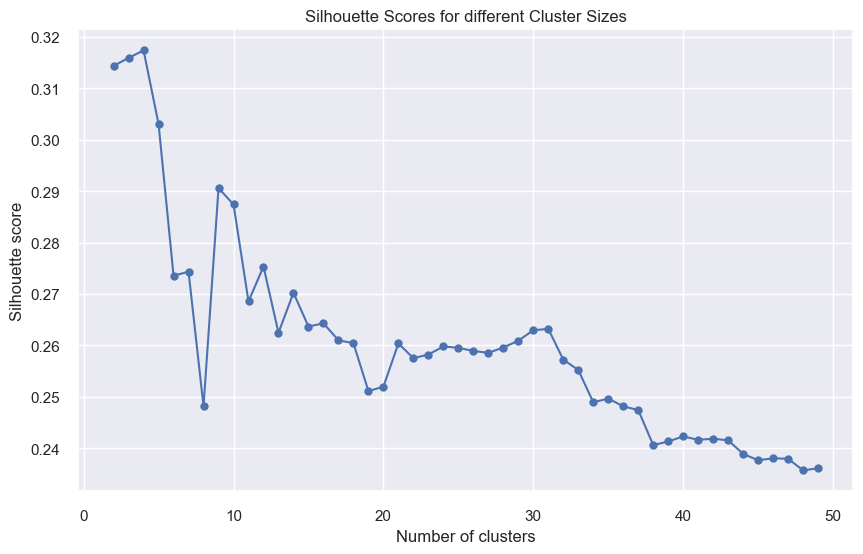

In [26]:
def calculate_silhouette_scores(scaled_df, range_of_clusters):
    # Initializing Silhouette Scores List
    silhouette_scores = []

    # Looping through Cluster Sizes
    for k in range_of_clusters:
        # Fitting the KMeans Model
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_df)
        
        # Predicting cluster labels
        cluster_labels = kmeans.labels_
        
        # Calculating Silhouette Score
        silhouette_avg = silhouette_score(scaled_df, cluster_labels)
        
        # Storing Silhouette Scores
        silhouette_scores.append(silhouette_avg)
        
        # Printing Results
        print(f'Number of clusters: {k}, Silhouette score: {silhouette_avg}')

    # Plotting Cluster Sizes vs Silhouette Scores
    plt.figure(figsize=(10, 6))
    plt.plot(range_of_clusters, silhouette_scores, marker='o', linestyle='-')
    
    # Setting Labels and Title
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette Scores for different Cluster Sizes')
    
    # Displaying Plot
    plt.show()

# Example usage:
calculate_silhouette_scores(subset_scaled_df, range(2, 50))

**4) Based on the analysis using both the elbow method and silhouette scores, which value of k would you select as the optimal number of clusters? (5 points)**

write your answer here ->
Based on the silhouette score, I would probably choose k=3, since it has the highest silhouette score.
Based on the elbow plot, I would have chosen k = 6, because, that appears to be where the elbow is.
I think the optimal k would be an average of both methods, so id say the optimal would be k = 4


**5) Now, write code to fit KMeans clusters for the number of clusters (k) that you determined to be optimal based on your analysis. (10 points)**

In [74]:
# Fit KMeans with optimal number of clusters
optimal_cluster = 4

kmeans = KMeans(n_clusters=optimal_cluster, random_state=42)
kmeans.fit(subset_scaled_df)

# Get cluster labels
cluster_labels = kmeans.labels_
print("Cluster labels:")
print(cluster_labels)

Cluster labels:
[0 0 0 ... 3 1 1]


In [75]:
# adding kmeans cluster labels to the original and scaled dataframes
df["K_means_segments"] = kmeans.labels_
subset_scaled_df["K_means_segments"] = kmeans.labels_

# Task 5 - Cluster Profiling

In [76]:
numeric_cols = df.select_dtypes(include=[np.number])
cluster_profile = numeric_cols.groupby("K_means_segments").mean()

In [77]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("K_means_segments")["Sale_Price"].count().values
)

In [78]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Listing_Price,Sale_Price,Discount,Rating,Reviews,count_in_each_segments
K_means_segments,,,,,,
0,6689.235690,3657.606061,44.882155,3.476768,23.750842,891
1,3926.290698,7973.769767,0.116279,3.092326,25.995349,860
2,7022.250000,3900.506809,43.531128,3.204183,72.922179,1028
3,15178.034946,12706.637097,7.930108,3.500269,36.336022,372


**The following code generates a set of boxplots to visualize the distribution of original numerical variables for each cluster obtained from KMeans clustering.**

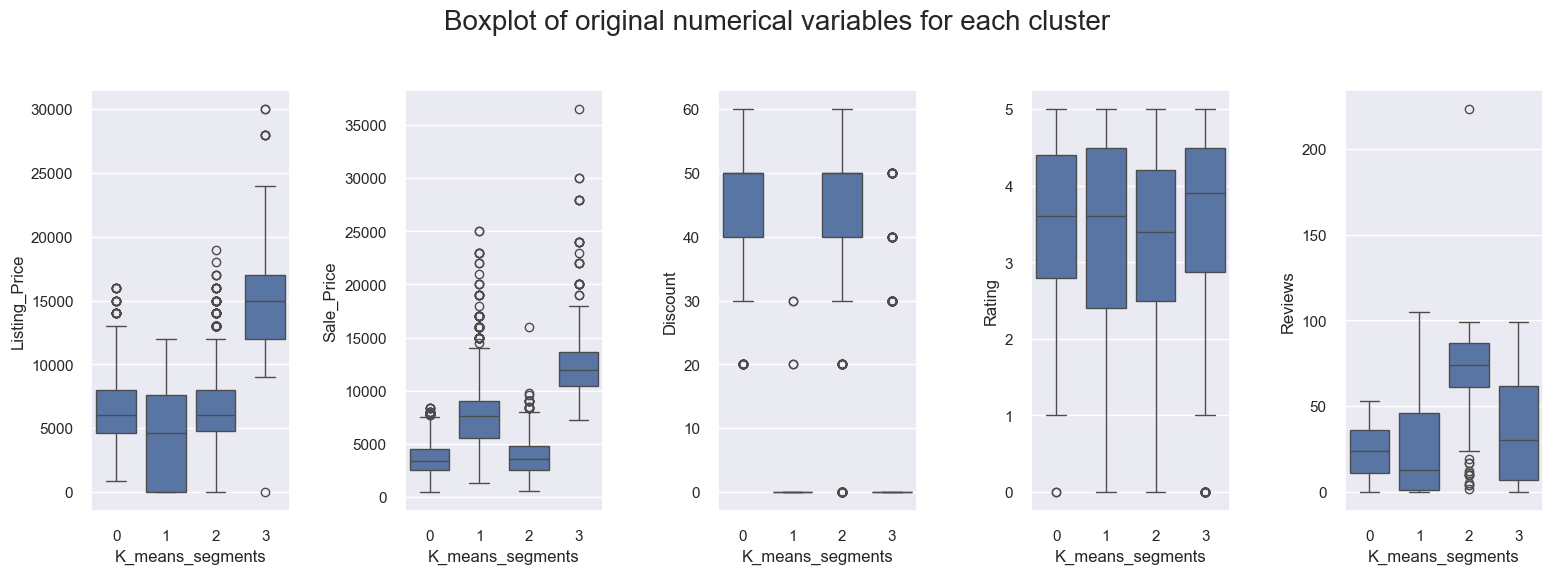

In [79]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for i in range(5):
    sns.boxplot(ax=axes[i], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

**1) After analyzing the boxplots generated above for each cluster, please provide 2 insights for each cluster. (10 points)**

Write your answer here -->
- Listing Price: Doesnt seem like there is much difference between clusters 0,1 and 4 for listing price. There was good seperation between cluster 2 and 5 from the other cluster.
- Sale Price: There was very good seperation between all clusters. However, clusters 2 and 5 look like they could have been combined into one cluster, ideally.
- Discount:Clusters 0 and 4 could have been combined considering how closely related they are. Cluster 2's distribution was to be expected.
- Rating: There is very little clustering going on between clusters 0-4 for Rating. This is to be expected since we saw earliter that ratings were pretty evenly distributed. 
- Reviews: There was some good sperations between clusters 0,3,4. Clusters 1 and 2 probably could have been combined.The algorithm did something intereseting by putting outliers in the 5th cluster for some reason


# Submission Guidelines:


- Your assignment should be **submitted as a Jupyter Notebook** containing the code, visualizations, and comments explaining your analysis and findings.
- Ensure your code is well-commented to explain the purpose of your code.
- You must implement the whole assignment by yourself. Academic dishonety will have serious consequences.
- Title your notebooks as **"LAST_NAME_A3.ipnyb"**. Failure to adhere to the naming format may result in a 5-point deduction from the total score.
- **Submit your notebook via the Canvas before the deadline (04/12/2024, 10:59PM).**

##Grading Criteria:
Task 1: 10 pts

Task 2: 20 pts

Task 3: 10 pts

Task 4: 50 pts

Task 5: 10 pts


Good luck!